In [1]:
import os
import numpy as np
# from ultrack import MainConfig, load_config, track, to_tracks_layer, tracks_to_zarr
import zarr
import pandas as pd
from pathlib import Path
from scipy.interpolate import interp1d
from scipy.interpolate import UnivariateSpline
from src.cell_dynamics.cell_dynamics import geodesic_distances_on_sphere, smooth_tracks_savgol

## Load data

In [2]:
# set parameters
root = Path("E:\\Nick\\killi_immuno_paper\\")

# load raw image
project_name = "20241126_LCP1-NLSMSC"
image_zarr = os.path.join(root, "built_data", "zarr_image_files",  project_name + ".zarr")

# Make figure path
figure_path =  root / "figures" / "paper_figures"
figure_path.mkdir(parents=True, exist_ok=True)

# load masks
mpath = root / "built_data" / "mask_stacks" /f"{project_name}_mask_aff.zarr"
mask = zarr.open(mpath, mode="r")

# load tracks
tracking_config = "tracking_lcp_nuclei" #"tracking_20250328_redux"
start_i = 0
stop_i = 719 # 614
suffix = ""
scale_vec = np.asarray([mask.attrs['PhysicalSizeZ'], mask.attrs['PhysicalSizeY'], mask.attrs['PhysicalSizeX']])

track_path = Path(os.path.join(root, "tracking", project_name, tracking_config))
# load track df
# print("Loading track data...")
tracks_df_raw = pd.read_csv(track_path / f"track_{start_i:04}_{stop_i:04}{suffix}" / "tracks_stitched.csv")

tracks_df_raw[["z", "y", "x"]] = np.multiply(tracks_df_raw[["z", "y", "x"]].to_numpy(), scale_vec[None, :])
# load sphere fit
sphere_path = os.path.join(root, "tracking", project_name)
sphere_df = pd.read_csv(os.path.join(sphere_path, "sphere_fit.csv"))

## Get wound center

In [3]:
# make array to specify wound location
wound_xy_df = pd.read_csv(os.path.join(sphere_path, "wound_center.csv"))
frame_vec_full = sphere_df.loc[:, "t"].to_numpy()

# fit separate splines for x and y
spline_x = UnivariateSpline(wound_xy_df["frame"], wound_xy_df["x"], k=3, s=5)  # s is smoothing factor
spline_y = UnivariateSpline(wound_xy_df["frame"], wound_xy_df["y"], k=3, s=5)

# evaluate on full frame vector
x_long = spline_x(frame_vec_full)
y_long = spline_y(frame_vec_full)

# assign back
wound_df = sphere_df.copy()
wound_df[["xw", "yw"]] = np.column_stack([x_long, y_long])

# solve for z
z_sol = np.sqrt(wound_df["r"]**2 - (wound_df["xs"]-wound_df["xw"])**2 - (wound_df["ys"]-wound_df["yw"])**2) + wound_df["zs"]
wound_df["zw"] = z_sol

### Apply mild S-G smoothing tracks

In [4]:
tracks_df = tracks_df_raw.loc[tracks_df_raw["track_mostly_stationary"]==False]
tracks_df = tracks_df[tracks_df["track_len"]>=15]
tracks_df = smooth_tracks_savgol(tracks_df, window=5, poly=2)
tracks_df = tracks_df.rename(columns={"x":"x_raw", "y":"y_raw", "z":"z_raw"})
tracks_df = tracks_df.rename(columns={"x_smooth":"x", "y_smooth":"y", "z_smooth":"z"})
tracks_df.head()

track_id   t  z_raw  y_raw  x_raw          id  parent_track_id   parent_id  \
0         1   6  447.0  673.6  528.8   7000016.0               -1        -1.0   
1         1   7  444.0  671.2  529.6   8000015.0               -1   7000016.0   
2         1   8  444.0  670.4  530.4   9000016.0               -1   8000015.0   
3         1   9  447.0  668.0  534.4  10000016.0               -1   9000016.0   
4         1  10  447.0  667.2  535.2  11000020.0               -1  10000016.0   

   track_len   dx   dy   dz  step_len  roll_move  is_stationary  \
0         15  NaN  NaN  NaN       NaN        NaN          False   
1         15  1.0 -3.0 -1.0  3.316625   3.316625          False   
2         15  1.0 -1.0  0.0  1.414214   2.365419          False   
3         15  5.0 -3.0  1.0  5.916080   3.548973          False   
4         15  1.0 -1.0  0.0  1.414214   3.015283          False   

   track_mostly_stationary           x           y           z  
0                    False  528.617143  673.508571  446.485714  
1                    False  529.691429  671.565714  444.857143  
2                    False  531.222857  669.851429  444.514286  
3                    False  533.714286  668.411429  446.485714  
4                    False  535.131429  667.062857  446.485714

## Estimate distance to wound center for each track

In [5]:
from tqdm import tqdm 
dT = 60
tracks_df_dist = geodesic_distances_on_sphere(tracks_df, wound_df)

tracks_df_dist["net_vel"] = (
    tracks_df_dist.groupby("track_id")["d_geo"].diff() / dT * 60
)
# tracks_df_dist = tracks_df_dist.drop(columns=["x_raw", "y_raw", "z_raw"], axis=1)
# save
tracks_df_dist.to_csv(track_path / "tracks_geo.csv", index=False)
tracks_df_dist.head()

track_id   t  z_raw  y_raw  x_raw          id  parent_track_id   parent_id  \
0         1   6  447.0  673.6  528.8   7000016.0               -1        -1.0   
1         1   7  444.0  671.2  529.6   8000015.0               -1   7000016.0   
2         1   8  444.0  670.4  530.4   9000016.0               -1   8000015.0   
3         1   9  447.0  668.0  534.4  10000016.0               -1   9000016.0   
4         1  10  447.0  667.2  535.2  11000020.0               -1  10000016.0   

   track_len   dx  ...          xs           r          xw          yw  \
0         15  NaN  ...  610.848183  529.318986  596.405129  752.359367   
1         15  1.0  ...  611.410173  530.262738  597.390039  751.901102   
2         15  1.0  ...  610.264330  529.221176  598.353370  751.440239   
3         15  5.0  ...  615.051781  529.807164  599.295388  750.976933   
4         15  1.0  ...  615.729344  529.568777  600.216360  750.511336   

           zw     theta       d_geo     d_chord       phi   net_vel  
0  455.922354  0.198306  104.967062  104.411250  3.851691       NaN  
1  455.006532  0.200058  106.083421  105.545660  3.841833  1.116359  
2  454.480668  0.201587  106.684245  106.125249  3.830077  0.600824  
3  454.652452  0.200806  106.388574  105.757454  3.812843 -0.295670  
4  454.798047  0.201654  106.789524  106.154565  3.803983  0.400950  

[5 rows x 31 columns]

## Calculate motility metrics over time

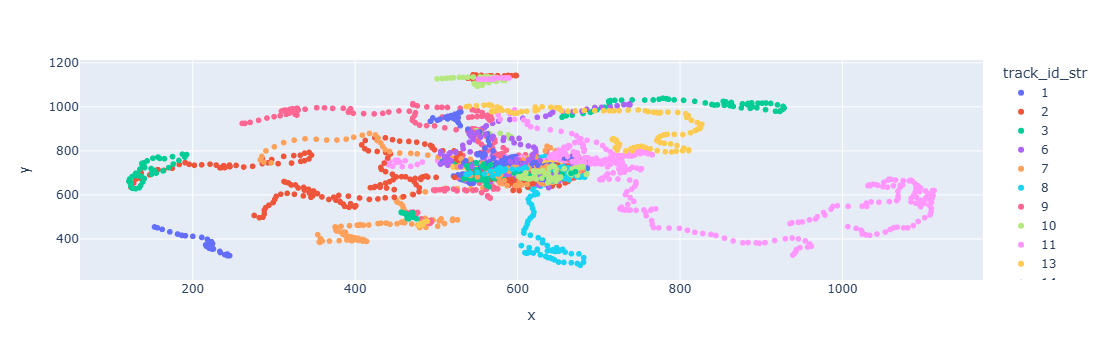

In [6]:
import plotly.express as px

wound_thresh = 100
track_type_df = (
    tracks_df_dist
    .groupby("track_id")
    .agg(
        d_geo_min = ("d_geo", "min"),
        d_geo_max = ("d_geo", "max"),
        net_vel_mean = ("net_vel", "mean"),
    )
    .reset_index()
)
track_type_df["in_wound_flag"] = track_type_df["d_geo_min"] <= wound_thresh
track_type_df["out_wound_flag"] = track_type_df["d_geo_max"] > wound_thresh
track_type_df["to_wound"] = track_type_df["net_vel_mean"] < 0
track_type_df["from_wound"] = track_type_df["net_vel_mean"] > 0


tracks_df_dist["track_id_str"] = tracks_df_dist["track_id"].astype(str)

px.scatter(tracks_df_dist.loc[tracks_df_dist["t"]<240], x="x", y="y", color="track_id_str")

In [7]:
from src.cell_dynamics.cell_dynamics import compute_windowed_msd, compute_windowed_autocorr
from tqdm import tqdm

W = 25  # 30 minutes
step = 1  # no overlap
tids, tids_c = np.unique(tracks_df_dist['track_id'], return_counts=True)

valid_tids = tids[tids_c >= W]

msd_df_list = []
ac_df_list  = []

for tid in tqdm(valid_tids):
    track = tracks_df_dist[tracks_df_dist['track_id'] == tid].sort_values('t')
    t_vec = track["t"].to_numpy()

    pos     = track[['x','y','z']].to_numpy(float)
    pos_raw = track[['x_raw','y_raw','z_raw']].to_numpy(float)

    # ---------------- MSD ----------------
    msd_res = compute_windowed_msd(pos, W=W, step=step)
    if len(msd_res) > 0:
        msd_df = pd.DataFrame(msd_res)
        msd_df["track_id"] = tid

        # ---- define indices ONCE ----
        start_idx = msd_df["start_idx"].to_numpy()
        end_idx   = msd_df["end_idx"].to_numpy()       # exclusive
        end_idx_inclusive = np.minimum(end_idx - 1, len(track) - 1)

        # ---- compute window times ONCE ----
        start_times = t_vec[start_idx]
        end_times   = t_vec[end_idx_inclusive]
        msd_df["time"] = (start_times + end_times) / 2

        # ---- window averages (use precomputed idx arrays) ----
        netvel_avg = []
        dgeo_avg   = []

        for s, e_excl in zip(start_idx, end_idx):
            e = min(e_excl, len(track))    # slice end is exclusive
            window = track.iloc[s:e]
            netvel_avg.append(window["net_vel"].mean())
            dgeo_avg.append(window["d_geo"].mean())

        msd_df["net_vel_avg"] = netvel_avg
        msd_df["d_geo_avg"]   = dgeo_avg

        msd_df_list.append(msd_df)

    # ---------------- Autocorr ----------------
    ac_res = compute_windowed_autocorr(pos_raw, W=W, step=step)
    if len(ac_res) > 0:
        ac_df = pd.DataFrame(ac_res)
        ac_df["track_id"] = tid

        # ---- define indices ONCE ----
        start_idx = ac_df["start_idx"].to_numpy()
        end_idx   = ac_df["end_idx"].to_numpy()
        end_idx_inclusive = np.minimum(end_idx - 1, len(track) - 1)

        # ---- compute midpoint times ONCE ----
        start_times = t_vec[start_idx]
        end_times   = t_vec[end_idx_inclusive]
        ac_df["idx"] = (start_times + end_times) / 2

        # ---- window averages ----
        netvel_avg = []
        dgeo_avg   = []

        for s, e_excl in zip(start_idx, end_idx):
            e = min(e_excl, len(track))
            window = track.iloc[s:e]
            netvel_avg.append(window["net_vel"].mean())
            dgeo_avg.append(window["d_geo"].mean())

        ac_df["net_vel_avg"] = netvel_avg
        ac_df["d_geo_avg"]   = dgeo_avg

        ac_df_list.append(ac_df)

# ---------------- Final merge ----------------
ac_df_full  = pd.concat(ac_df_list,  ignore_index=True)
ac_df_full = ac_df_full.merge(track_type_df, how="left", on="track_id")
msd_df_full = pd.concat(msd_df_list, ignore_index=True)
msd_df_full = msd_df_full.merge(track_type_df, how="left", on="track_id")

100%|██████████| 98/98 [00:08<00:00, 12.17it/s]


In [51]:
# plot_filter = msd_df_full["d_geo_avg"]>75
# fig = px.scatter(msd_df_full.loc[plot_filter], x="net_vel_avg", y="alpha", color="idx")
# fig.show()

In [8]:
# plot_filter = (msd_df_full["time"]<=120) & (msd_df_full["in_wound_flag"]) & (msd_df_full["out_wound_flag"]) & (msd_df_full["to_wound"]) 
# fig = px.scatter(msd_df_full.loc[plot_filter], x="d_geo_avg", y="alpha", trendline="lowess", color="track_id", opacity=1)
# fig.show()

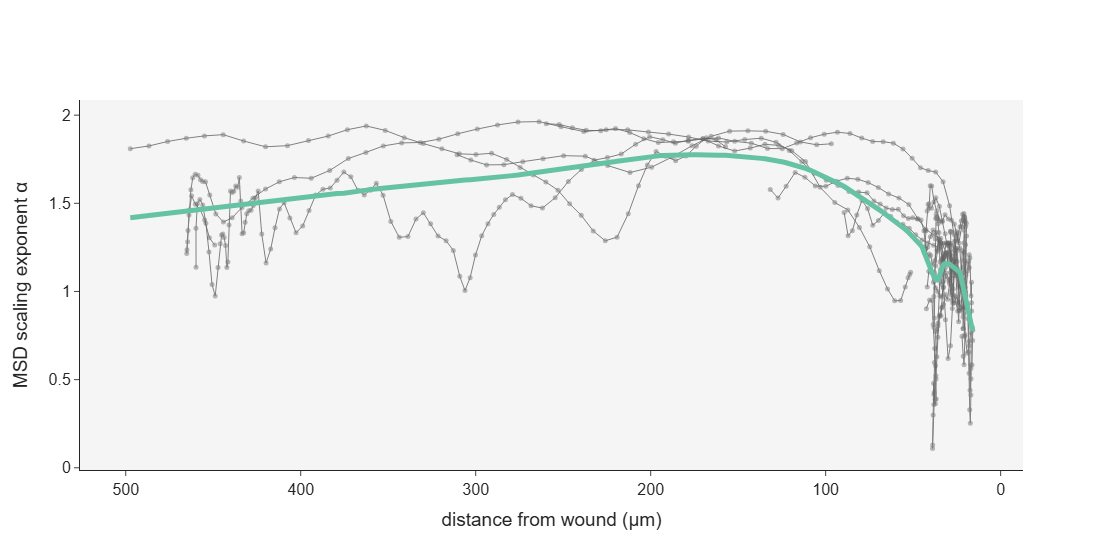

In [9]:
import plotly.graph_objects as go
from statsmodels.nonparametric.smoothers_lowess import lowess

plot_filter = (msd_df_full["time"]<=120) & (msd_df_full["in_wound_flag"]) & (msd_df_full["out_wound_flag"]) & (msd_df_full["to_wound"]) 

df = msd_df_full.loc[plot_filter].copy()
x_col="d_geo_avg"
y_col="alpha"
group_col="track_id"
frac=0.25
trend_color = "#66C2A5"

# -----------------------------------------
# Compute overall LOWESS smooth
# -----------------------------------------
sm = lowess(df[y_col], df[x_col], frac=frac, it=0)
trend_x, trend_y = sm[:,0], sm[:,1]

# -----------------------------------------
# Build figure
# -----------------------------------------
fig = go.Figure()

# Raw traces, all same color
for tid, sub in df.groupby(group_col):
    fig.add_trace(go.Scatter(
        x=sub[x_col],
        y=sub[y_col],
        mode="markers+lines",
        line=dict(width=1, color="#636363"),     # muted grey
        marker=dict(size=5, opacity=0.55, color="#636363"),
        name=str(tid),
        showlegend=False,                        # hide individual legend items
        opacity=0.8
    ))

# Population-level smooth
fig.add_trace(go.Scatter(
    x=trend_x,
    y=trend_y,
    mode="lines",
    line=dict(width=5, color=trend_color),
    showlegend=False  #"Population LOWESS",
))

# -----------------------------------------
# Aesthetics (ggplot-like)
# -----------------------------------------
fig.update_layout(
    template="simple_white",
    plot_bgcolor="#f5f5f5",
    paper_bgcolor="white",
    width=900,
    height=550,
    font=dict(family="Arial", size=16),
    xaxis=dict(
        title="distance from wound (µm)",
        autorange="reversed",                # <--- REVERSE X AXIS
        gridcolor="white",
        zerolinecolor="white",
    ),
    yaxis=dict(
        title="MSD scaling exponent α",
        gridcolor="white",
        zerolinecolor="white",
    ),
    legend=dict(
        bgcolor="rgba(255,255,255,0.6)"
    )
    )

fig.show()

fig.write_image(figure_path / "MSD_to_wound_0-2hrs.png")

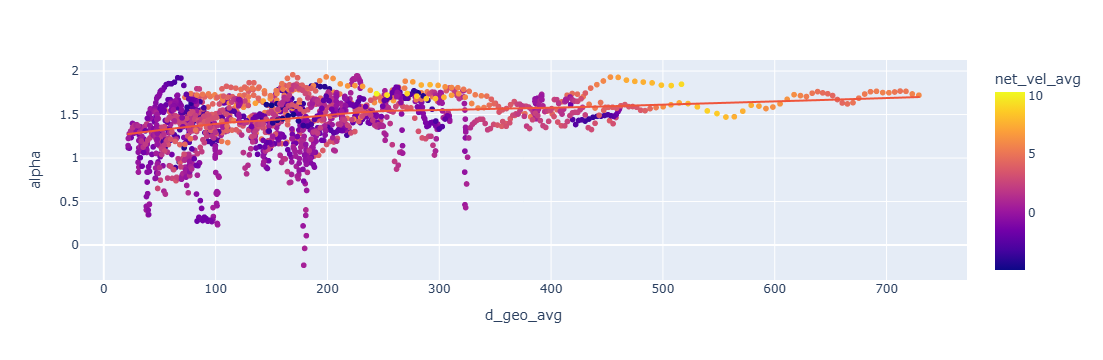

In [11]:
plot_filter = (msd_df_full["time"]>=300) & (msd_df_full["in_wound_flag"]) & (msd_df_full["from_wound"]) 
fig = px.scatter(msd_df_full.loc[plot_filter], x="d_geo_avg", y="alpha", trendline="lowess", color="net_vel_avg", opacity=1)
fig.show()

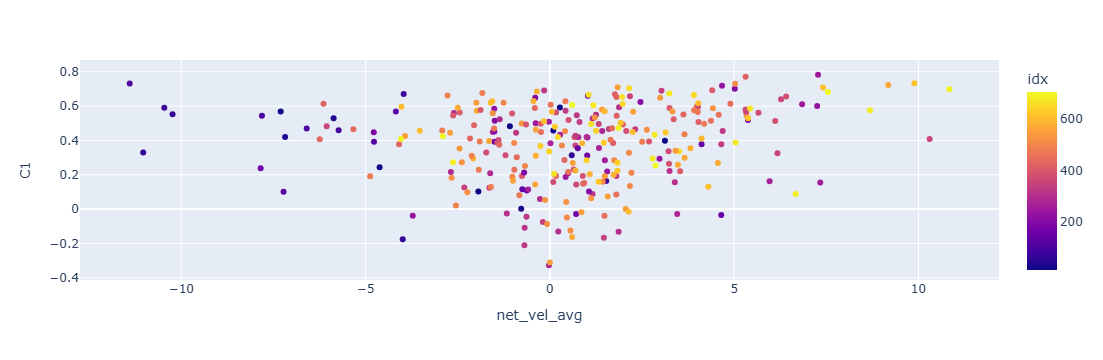

In [18]:
plot_filter = ac_df_full["d_geo_avg"]>75
fig = px.scatter(ac_df_full.loc[plot_filter], x="net_vel_avg", y="C1", color="idx")
fig.show()

In [18]:
ac_df_full.head()

start_idx  end_idx        C1  mean_cos_theta  track_id   idx
0          0       30  0.343347        0.512313         3  14.5
1          5       35  0.398493        0.577452         3  19.5
2          0       30  0.362124        0.439351         4  14.5
3          5       35  0.324215        0.443887         4  19.5
4         10       40  0.333119        0.415344         4  24.5

## Polar plots of mean net velocity over time

In [20]:
dT = 60
track_avg_window = 15
angle_bins = np.linspace(0, 2*np.pi, 11)
da = angle_bins[1] - angle_bins[0]
time_bins = np.array([0, 2, 5, 7])*3600 #np.linspace(0, 10*3600, 21) 

tracks_df_dist["time"] = tracks_df_dist["t"]*dT
tracks_df_dist["angle_bin"] = np.digitize(tracks_df_dist["phi"], angle_bins)
tracks_df_dist["angle_bin"] = (tracks_df_dist["angle_bin"] - 0.5)*da
tracks_df_dist["time_bin"] = np.digitize(tracks_df_dist["time"], time_bins)

# 1) per-track displacement per frame
tracks_df_dist["net_vel"] = (
    tracks_df_dist.groupby("track_id")["d_geo"].diff() / dT * 60
)

# 2) smoothed velocity using a centered rolling mean per track
# tracks_df_dist["net_vel_sm"] = (
#     tracks_df_dist.groupby("track_id")["net_vel"]
#     .transform(lambda s: s.rolling(window=avg_window, min_periods=1, center=True).mean())
# )

vel_df = tracks_df_dist.loc[:, ["time_bin", "angle_bin", "net_vel"]].dropna().groupby(["time_bin", "angle_bin"]).mean().reset_index()
vel_df.head()

time_bin  angle_bin   net_vel
0         1   0.314159 -1.054531
1         1   0.942478 -0.374476
2         1   1.570796  0.340497
3         1   2.199115 -0.567061
4         1   2.827433 -1.350732

In [21]:
import numpy as np
import matplotlib.pyplot as plt

def circular_bar_clock(
    df, time_bin, angle_col="phi", value_col="v", time_col="t",
    r_outer=2.0,                 # full radial extent, **in velocity units**
    bar_width_deg=12,            # angular width (degrees)
    pos_color="#c51b7d",         # brighter PiYG pink (v>0 = inward)
    neg_color="#4d9221",         # brighter PiYG green (v<0 = outward)
    edgecolor="black", linewidth=0.6, joinstyle="miter",
    theta_zero="N", theta_dir=-1,   # clock orientation
    units=None,                  # e.g. "µm/s"
    tick_step=None,              # step for signed tick labels (in velocity units), None = auto
    show_angle_labels=False, show_zero_ring=True,
    title_string=None,
    figsize=(6.4, 6.4)
):
    """
    Plot a 'clock' polar bar chart with absolute scaling:

    - Baseline at r0 = r_outer/2 (0 velocity).
    - v > 0 (pos_color) draws INWARD with bar length = v.
    - v < 0 (neg_color) draws OUTWARD with bar length = |v|.
    - Axis limits are [0, r_outer] in the same units as v.
    - Bars are clipped if they exceed available space (can't cross the center or outer edge).
    """
    d = df[df[time_col] == time_bin]
    if d.empty:
        raise ValueError(f"No rows for {time_col}={time_bin}")

    phi = d[angle_col].to_numpy(float)   # radians
    v   = -d[value_col].to_numpy(float)

    # Geometry: absolute scale
    r0 = float(r_outer) / 2.0            # 0 velocity at mid-radius
    bw = np.deg2rad(bar_width_deg)

    fig, ax = plt.subplots(subplot_kw={"projection": "polar"}, figsize=figsize)
    ax.set_theta_zero_location(theta_zero)
    ax.set_theta_direction(theta_dir)
    ax.set_rlim(0, r_outer)

    # Split by sign and clip so we don't go below 0 or above r_outer
    mask_pos = v > 0    # inward bars
    mask_neg = v < 0    # outward bars

    if np.any(mask_pos):
        v_pos = v[mask_pos]
        # inward bars can't extend past r=0
        v_pos_clip = np.minimum(v_pos, r0)
        ax.bar(
            phi[mask_pos], v_pos_clip,         # height = magnitude
            width=bw,
            bottom=(r0 - v_pos_clip),          # start inward so top ends at r0
            align="center",
            color=pos_color,
            edgecolor=edgecolor, linewidth=linewidth, joinstyle=joinstyle, antialiased=True
        )

    if np.any(mask_neg):
        v_neg = -v[mask_neg]                   # magnitude for outward bars
        # outward bars can't extend past r_outer
        v_neg_clip = np.minimum(v_neg, r_outer - r0)
        ax.bar(
            phi[mask_neg], v_neg_clip,         # height = magnitude
            width=bw,
            bottom=np.full(mask_neg.sum(), r0),# start at baseline, go outward
            align="center",
            color=neg_color,
            edgecolor=edgecolor, linewidth=linewidth, joinstyle=joinstyle, antialiased=True
        )

    # Optional baseline ring at 0
    if show_zero_ring:
        th = np.linspace(0, 2*np.pi, 721)
        ax.plot(th, np.full_like(th, r0), lw=1, ls="--", color="0.4")

    # --- Radial ticks with signed labels in your units ---
    # choose a nice tick step if not given
    max_span = max(r0, r_outer - r0)  # same here (r_outer/2), but keep general
    if tick_step is None:
        # crude "nice" step: 4 ticks to the baseline
        raw = max_span / 4.0
        pow10 = 10 ** np.floor(np.log10(raw)) if raw > 0 else 1.0
        frac = raw / pow10
        nice = 1 if frac < 1.5 else 2 if frac < 3.5 else 5
        tick_step = nice * pow10

    # build symmetric ticks around r0, labeled as signed velocities
    pos_ticks = np.arange(tick_step, max_span + 1e-9, tick_step)
    rticks = np.concatenate([r0 - pos_ticks[::-1], [r0], r0 + pos_ticks])
    labels = [f"+{t:.3g}" + (f" {units}" if units else "") for t in pos_ticks[::-1]]
    labels += ["0"]
    labels += [f"-{t:.3g}" + (f" {units}" if units else "") for t in pos_ticks]

    # keep ticks within [0, r_outer]
    keep = (rticks >= 0) & (rticks <= r_outer)
    rticks = rticks[keep]
    labels = [lab for lab, k in zip(labels, keep) if k]

    ax.set_rticks(rticks)
    ax.set_yticklabels(labels)
    ax.set_rlabel_position(180)  # put labels at 3 o'clock; adjust if you like
    ax.tick_params(axis="y", pad=6)

    if title_string:
        ax.set_title(title_string)
        
    if not show_angle_labels:
        ax.set_xticklabels([])

    return fig, ax, {"r0": r0, "r_outer": r_outer, "tick_step": tick_step}


  0%|          | 0/1 [00:00<?, ?it/s]

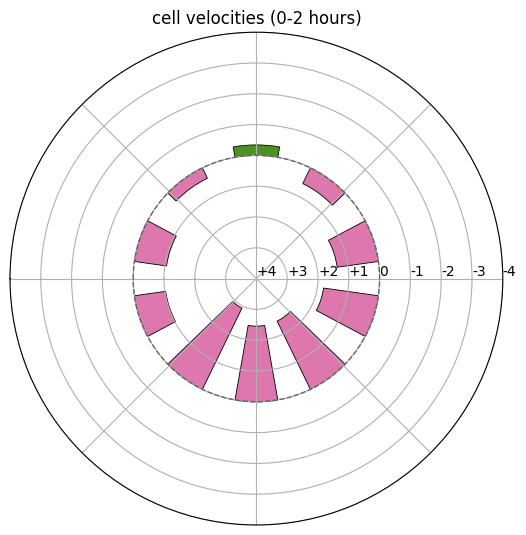

100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


In [22]:
OUTDIR = Path(r"E:\Nick\killi_tracker\figures\syd_paper") / project_name / "vel_plots_ap_vert"
OUTDIR.mkdir(parents=True, exist_ok=True)

tb = vel_df["time_bin"].unique()
title_dict = {1:f"cell velocities (0-2 hours)",
              2:f"cell velocities (2-5 hours)",
              3:f"cell velocities (5-7 hours)",
              4:f"cell velocities (7+ hours)",}

theme_vec = ["light", "dark"]

for theme in theme_vec[:1]:
    for time_bin in tqdm(tb[:1]):
    
        fig, ax, _ = circular_bar_clock(vel_df, time_bin=time_bin, angle_col="angle_bin", value_col="net_vel", time_col="time_bin",
                                     pos_color="#de77ae", neg_color="#4d9221", bar_width_deg=20, r_outer=8, title_string=title_dict[time_bin])
    
        # --- DARK THEME SETTINGS ---
        if theme=="dark":
            fig.patch.set_facecolor("black")          # figure background
            ax.set_facecolor("black")                 # axes background
            
            # Make all text, spines, ticks white
            ax.tick_params(colors="white")
            
            for spine in ax.spines.values():
                spine.set_color("white")
            
            ax.title.set_color("white")
            ax.xaxis.label.set_color("white")
            ax.yaxis.label.set_color("white")
        
            for p in ax.patches:
                p.set_edgecolor("white")
                p.set_linewidth(0.8)
                
            # If you have polar/radial text:
            for t in ax.get_xticklabels() + ax.get_yticklabels():
                t.set_color("white")

        # ax.set_theta_direction(-1)  # reverse angular direction
        # ax.set_phi_offset(0.5*np.pi)  # optional: re-anchor at 180°
        # ax.set_theta_direction(-ax.get_theta_direction())
        # ax.set_theta_offset(np.pi - ax.get_theta_offset())
        ax.set_theta_offset(np.pi)
        
        fig.savefig(OUTDIR / f"vel_plot_{time_bin:03}_{theme}.png", dpi=600)

        plt.show()
        plt.close()

In [16]:
tracks_df_dist.head()

track_id   t      z      y      x        id  parent_track_id  parent_id  \
0         1   6  447.0  673.6  528.8   7000016               -1         -1   
1         1   7  444.0  671.2  529.6   8000015               -1    7000016   
2         1   8  444.0  670.4  530.4   9000016               -1    8000015   
3         1   9  447.0  668.0  534.4  10000016               -1    9000016   
4         1  10  447.0  667.2  535.2  11000020               -1   10000016   

          zs          ys  ...          yw          zw     theta       d_geo  \
0 -58.673760  629.230059  ...  752.359367  455.922354  0.197897  104.750746   
1 -60.489595  628.427418  ...  751.901102  455.006532  0.200783  106.467513   
2 -60.398935  629.652817  ...  751.440239  454.480668  0.201849  106.822635   
3 -60.421368  627.906518  ...  750.976933  454.652452  0.200562  106.259245   
4 -60.202003  628.129208  ...  750.511336  454.798047  0.201324  106.615013   

      d_chord       phi  time  angle_bin  time_bin   net_vel  
0  104.178211  3.850929   360    4.08407         1       NaN  
1  105.968396  3.840261   420    4.08407         1  1.716767  
2  106.278056  3.839381   480    4.08407         1  0.355122  
3  105.617909  3.805317   540    4.08407         1 -0.563390  
4  105.965633  3.804269   600    4.08407         1  0.355768  

[5 rows x 23 columns]

# Calculate mean new velocity wrpt wound center

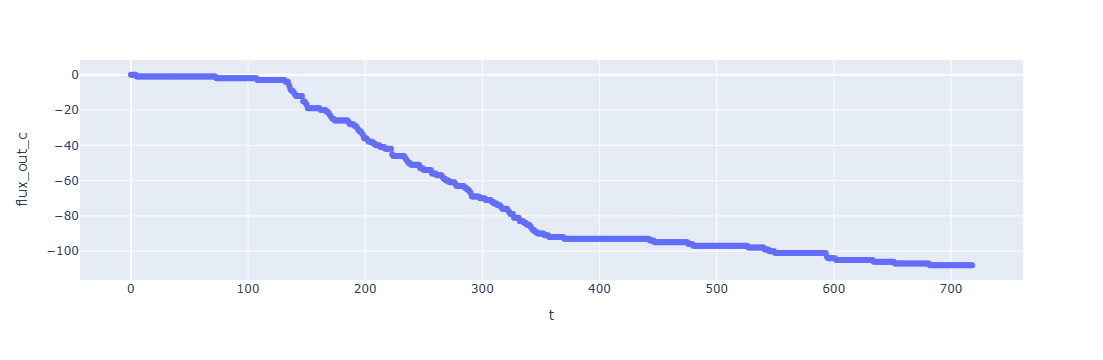

In [46]:
import plotly.express as px

radius = 75
tracks_df_dist["at_wound"] = tracks_df_dist["d_geo"] <= radius
tracks_df_dist["change_flag"] = tracks_df_dist[["track_id","at_wound"]].groupby("track_id").diff()
tracks_df_dist["flux_in"] = 1*(tracks_df_dist["change_flag"]>0)
tracks_df_dist["flux_out"] = -1*(tracks_df_dist["change_flag"]<0)

wound_stat_df = (
    tracks_df_dist
      .loc[:, ["t", "at_wound", "change_flag", "d_geo", "flux_in", "flux_out"]]
      .groupby("t")
      .agg({
          "at_wound": "sum",
          "change_flag": "mean",
          "d_geo": "mean",
          "flux_in": "sum",
          "flux_out": "sum",
      })
      .reset_index()
)

wound_stat_df["flux_in_c"] = wound_stat_df["flux_in"].cumsum()
wound_stat_df["flux_out_c"] = wound_stat_df["flux_out"].cumsum()

fig = px.scatter(wound_stat_df, x="t", y="flux_out_c")
fig.show()

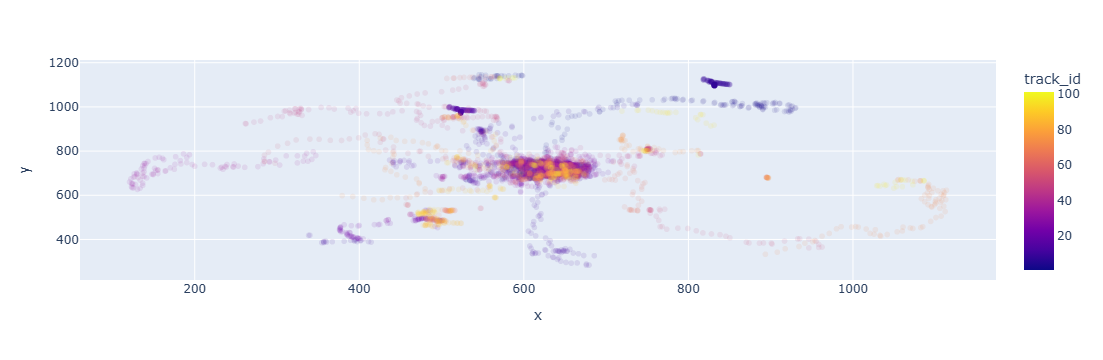

In [52]:
fig = px.scatter(tracks_df.loc[tracks_df["t"]<200], x="x", y="y", color="track_id", opacity=0.1)
tf = wound_df["t"] < 200
fig.add_traces(go.Scatter3d(x=wound_df.loc[tf, "xw"], y=wound_df.loc[tf, "yw"], mode="markers", 
                            marker=dict(opacity=1)))
fig.show()

## It's noisy counting neutrophils at the wound site so lets count entries and exits

## Calculate net velocities as a function of time and distance from the stab wound

In [8]:
def find_surface_point(raw_point, center_point, radius):
    # find closest point that is on the sphere
    c_vec = raw_point - center_point
    c_vec = c_vec / np.sqrt(np.sum(c_vec**2))
    r_vec = c_vec * radius
    surf_point = center_point + r_vec

    return surf_point

In [8]:
from tqdm import tqdm 
from astropy.coordinates import cartesian_to_spherical, spherical_to_cartesian

# set meanungful units
tres = 60
time_window = 10 # all calculations will be based on N-frame track fragments 

# loop through time points and get list of distances and signed velocities
master_vel_vec = []

for f in tqdm(range(wound_df.shape[0])):
    center_point = wound_df.loc[f, ["zs", "ys", "xs"]]
    radius = wound_df.loc[f, "r"]
    
    # get wound location
    wound_center_raw = wound_df.loc[f, ["zw", "yw", "xw"]
    
    # find closest point that is on the sphere
    wound_center = find_surface_point(wound_center_raw, center_point, radius)

    # add wound center info 
    wc = wound_center - center_point
    w_sph = cartesian_to_spherical(wc[2], wc[1], wc[0])
    w_sph = np.asarray([c.value for c in w_sph])
    # sphere_df_master_sm.loc[f, ["wound_z", "wound_y", "wound_x"]] = wound_center[:]
    # sphere_df_master_sm.loc[f, ["wound_r", "wound_phi", "wound_theta"]] = w_sph[:]
    
    # find extant tracks
    f_start = f
    f_stop = f + time_window-1
    tracks_filtered = tracks_df.loc[(tracks_df["t"]==f_start) | (tracks_df["t"]==f_stop), :].reset_index(drop=True)
    
    # find tracks that are present for entire window
    tracks_u, tracks_c = np.unique(tracks_filtered["track_id"], return_counts=True)

    tracks_to_use = tracks_u[tracks_c==2]

    vel_vec_temp = []
    for i, id in enumerate(tracks_to_use):
        # get start and end locations
        tracks_temp = tracks_filtered.loc[tracks_filtered["track_id"]==id, :].reset_index(drop=True)
        zyx0_raw = tracks_temp.loc[0, ["z", "y", "x"]].to_numpy()
        zyx1_raw = tracks_temp.loc[1, ["z", "y", "x"]].to_numpy()
        
        # get closest points on sphere surface
        zyx0 = find_surface_point(zyx0_raw, center_point, radius)
        zyx1 = find_surface_point(zyx1_raw, center_point, radius)
        d_cart = zyx1-zyx0
        
        # calculate distance to wound site
        d0 = np.sqrt(np.sum((wound_center-zyx0)**2))#2*radius*np.arcsin(np.sqrt(np.sum((wound_center-zyx0)**2))/(2*radius))
        d1 = np.sqrt(np.sum((wound_center-zyx1)**2))#2*radius*np.arcsin(np.sqrt(np.sum((wound_center-zyx1)**2))/(2*radius))

        # get spherical coordinates
        zyx0_c = zyx0 - center_point
        zyx1_c = zyx1 - center_point
        
        sph0 = cartesian_to_spherical(zyx0_c[2], zyx0_c[1], zyx0_c[0])
        sph0 = np.asarray([c.value for c in sph0])
        sph1 = cartesian_to_spherical(zyx1_c[2], zyx1_c[1], zyx1_c[0])
        sph1 = np.asarray([c.value for c in sph1])
        sph_d = sph1 - sph0
        master_vel_vec.append([id, f_start, d0, (d1-d0), sph0[0], sph0[1], sph0[2], sph_d[0], sph_d[1], sph_d[2],
                              zyx0[0], zyx0[1], zyx0[2], d_cart[0], d_cart[1], d_cart[2]])


    master_vel_vec.append(vel_vec_temp)
    

  0%|          | 0/719 [00:00<?, ?it/s]


NameError: name 'sphere_df_master_sm' is not defined

In [27]:
tracks_df.reset_index(drop=True, inplace=True)

for f in tqdm(frame_vec_full):
    center_point = sphere_df_master_sm.loc[f, ["Z", "Y", "X"]]
    radius = sphere_df_master_sm.loc[f, "r"]
    
    # get wound location
    wound_center_raw = wound_center_interp[f]
    # find closest point that is on the sphere
    wound_center = find_surface_point(wound_center_raw, center_point, radius)

    # add wound center info 
    wc = wound_center - center_point
    w_sph = cartesian_to_spherical(wc[2], wc[1], wc[0])
    w_sph = np.asarray([c.value for c in w_sph])
    # sphere_df_master_sm.loc[f, ["wound_z", "wound_y", "wound_x"]] = wound_center[:]
    # sphere_df_master_sm.loc[f, ["wound_r", "wound_phi", "wound_theta"]] = w_sph[:]
    
    # find extant tracks
    f_start = f
    f_stop = f + time_window-1
    # tracks_filtered = tracks_df.loc[(tracks_df["t"]==f_start), :].reset_index(drop=True)
    f_indices = np.where(tracks_df["t"]==f_start)[0]
    # find tracks that are present for entire window
    # tracks_u, tracks_c = np.unique(tracks_filtered["track_id"], return_counts=True)

    # tracks_to_use = tracks_u#[tracks_c==2]

    # vel_vec_temp = []
    for index in f_indices:
        # get start and end locations
        # tracks_temp = tracks_filtered.loc[tracks_filtered["track_id"]==id, :].reset_index(drop=True)
        zyx0_raw = tracks_df.loc[index, ["z", "y", "x"]].to_numpy()
        # zyx1_raw = tracks_temp.loc[1, ["z", "y", "x"]].to_numpy()
        
        # get closest points on sphere surface
        zyx0 = find_surface_point(zyx0_raw, center_point, radius)
        # zyx1 = find_surface_point(zyx1_raw, center_point, radius)
        # d_cart = zyx1-zyx0
        
        # calculate distance to wound site
        d0 = np.sqrt(np.sum((wound_center-zyx0)**2))#2*radius*np.arcsin(np.sqrt(np.sum((wound_center-zyx0)**2))/(2*radius))
        tracks_df.loc[index, "distance"] = d0 / 1.5

100%|██████████| 119/119 [00:15<00:00,  7.74it/s]


In [30]:
tracks_df.to_csv(os.path.join(root, "metadata", project_name, "tracks_df_dist.csv"), index=False)

In [31]:
tracks_df.head()

track_id  t    z      y      x       id  parent_track_id  parent_id  \
0         1  0  4.0   57.0  547.0  1000001               -1         -1   
1         1  1  4.0   58.0  550.0  2000001               -1    1000001   
2         1  2  2.0   56.0  549.0  3000001               -1    2000001   
3         2  0  5.0  103.0  254.0  1000002               -1         -1   
4         2  1  4.0  104.0  253.0  2000006               -1    1000002   

     distance  
0  354.794658  
1  354.442137  
2  356.504677  
3  359.381831  
4  359.656988

In [20]:
vel_df = pd.DataFrame(master_vel_vec, columns=["track_id", "frame", "d0", "net_distance", "r0", "phi0", "theta0", "r_d", "phi_d", "theta_d",
                                              "z0", "y0", "x0", "dz", "dy", "dx"])
vel_df.tail(5)

track_id  frame          d0  net_distance          r0      phi0  \
9942       410    109   72.616617      4.841385  390.616641  1.314369   
9943       412    109  408.547729      9.712332  390.616641  0.537324   
9944       413    109  484.266581     -1.071465  390.616641  0.175743   
9945       414    109   50.985954     29.465595  390.616641  1.369902   
9946       418    109   23.663060    -11.198067  390.616641  1.442649   

        theta0           r_d     phi_d   theta_d          z0          y0  \
9942  5.700296  5.684342e-14 -0.005734 -0.352975  314.292665  340.225862   
9943  2.893864  0.000000e+00 -0.029898  0.027459  136.380948  477.041243   
9944  0.045340  1.136868e-13  0.004951  0.035341    4.743717  412.189825   
9945  5.709104  0.000000e+00 -0.075463  0.095355  319.209071  352.428616   
9946  5.919437 -5.684342e-14  0.030770  0.014388  323.862017  376.997766   

              x0         dz         dy         dx  
9942  487.690916  -0.574236 -26.973568 -22.666694  
9943   79.651970 -10.120816  -7.689907  -7.822439  
9944  789.183876   1.903324  13.536772  -1.197556  
9945  470.429692  -6.965789  -6.766869  29.148863  
9946  451.632688   1.352420   4.761000 -10.970509

In [12]:
# import plotly.figure_factory as ff
# import plotly.express as px
# import plotly.graph_objects as go

# frames=np.asarray([10, 20, 30, 40, 50])
# ft = np.isin(vel_df["frame"],frames)
# fig = ff.create_quiver(x=vel_df.loc[ft, "x0"], y=vel_df.loc[ft, "y0"], u=vel_df.loc[ft, "dx"], v=vel_df.loc[ft, "dy"],
#                       marker_size=12, scale=1)

# fig.add_trace(go.Scatter(x=[wound_center_interp[frame, 2]], 
#                          y=[wound_center_interp[frame, 1]], mode="markers", marker=dict(size=10)))

# fig.update_layout(
#     autosize=False,
#     width=500,
#     height=500)

# fig.show()

## Do the great circle distances make sense?

In [21]:
for f in frame_vec_full:
    vel_df.loc[vel_df["frame"]==f,["wound_z", "wound_y", "wound_x"]] = np.tile(wound_center_interp[f, :], (np.sum(vel_df["frame"].to_numpy()==f), 1))

vel_df["x_rel"] = vel_df["x0"] - vel_df["wound_x"]
vel_df["y_rel"] = vel_df["y0"] - vel_df["wound_y"]
vel_df["t_polar"] = np.arctan2(vel_df["y_rel"], vel_df["x_rel"])
vel_df["x_polar"] = np.multiply(vel_df["d0"], np.cos(vel_df["t_polar"]))
vel_df["y_polar"] = np.multiply(vel_df["d0"], np.sin(vel_df["t_polar"]))
vel_df["u_polar"] = np.divide(np.multiply(vel_df["net_distance"], vel_df["x_polar"]), vel_df["d0"])
vel_df["v_polar"] = np.divide(np.multiply(vel_df["net_distance"], vel_df["y_polar"]), vel_df["d0"])

vel_df["frame_cat"] = vel_df["frame"].astype(str)
vel_df["net_vel"] = -vel_df["net_distance"] * 1.5 / time_window

vel_df.to_csv(os.path.join(root, "metadata", project_name, "velocity_df.csv"), index=False)

In [ ]:
# import matplotlib.pyplot as plt
# import matplotlib.cm as cm
# from matplotlib.colors import Normalize

# frames=np.arange(20, 50) #np.asarray([90, 95])

# ft = np.isin(vel_df["frame"],frames)

# vel_df["net_dist_norm"] = np.divide(vel_df["net_distance"], np.sqrt(vel_df["dx"]**2+vel_df["dy"]**2+vel_df["dz"]**2))

# x=vel_df.loc[ft, "x_polar"]
# y=vel_df.loc[ft, "y_polar"] 
# u=vel_df.loc[ft, "u_polar"]
# v=vel_df.loc[ft, "v_polar"]


# colors = vel_df.loc[ft, "net_dist_norm"].to_numpy()
# colors[np.isnan(colors)] = 0
# colors = np.clip(colors,-clip_val, clip_val)
# # ft = colors < 0
# colors = colors - np.min(colors)
# colors = colors / np.max(colors)

# colormap = cm.RdYlBu


# # pick your colormap here, refer to 
# # http://matplotlib.org/examples/color/colormaps_reference.html
# # and
# # http://matplotlib.org/users/colormaps.html
# # for details
# plt.figure(figsize=(6, 6))
# # plt.xlim(-2, 2)
# # plt.ylim(-2, 2)
# plt.quiver(x, y, u, v, color=colormap(colors), scale=0.75, angles='xy',scale_units='xy')
#            #scale_units='xy', scale=1, pivot='mid')

# plt.show()

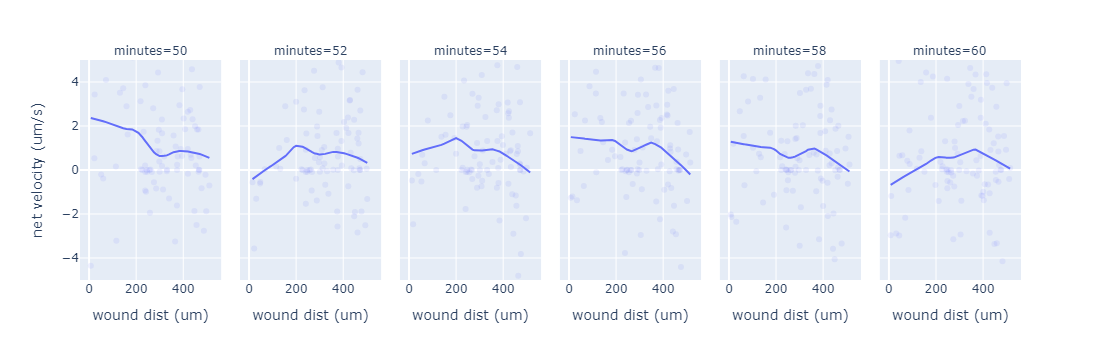

In [14]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize

frames=np.arange(50, 62, 2) # np.asarray([20, 30,  40, 50, 60, 70])
vel_df["net_vel"] = -vel_df["net_distance"] * 1.5 / time_window
ft = np.isin(vel_df["frame"],frames)

fig = px.scatter(vel_df.loc[ft], x="d0", y="net_vel", facet_col="frame",  trendline="lowess", opacity=0.1, 
                labels={"frame":"minutes", "net_vel": "net velocity (um/s)", "d0":"wound dist (um)"})
fig.update_yaxes(range=[-5, 5])               
# fig.update_layout(xaxis_title="distance from wound (um)", yaxis_title="net velocity toward wound (um/minute)")
fig.show()


In [15]:
def get_n_colors_from_colormap(colorscale_name, n_colors):
    # Get a Plotly colorscale by name
    colorscale = px.colors.get_colorscale(colorscale_name)

    sample_points = np.linspace(0,1,n_colors)
    # Sample n_colors from the colorscale
    sampled_colors = px.colors.sample_colorscale(colorscale, samplepoints=list(sample_points))
    
    return sampled_colors

# Example usage
colors = get_n_colors_from_colormap('Viridis', 15)
print(colors)

['rgb(68, 1, 84)', 'rgb(71, 26, 107)', 'rgb(69, 49, 125)', 'rgb(63, 71, 136)', 'rgb(55, 91, 140)', 'rgb(47, 110, 142)', 'rgb(40, 126, 142)', 'rgb(34, 144, 140)', 'rgb(34, 162, 135)', 'rgb(48, 178, 124)', 'rgb(77, 193, 107)', 'rgb(115, 207, 85)', 'rgb(161, 217, 56)', 'rgb(207, 225, 41)', 'rgb(253, 231, 37)']


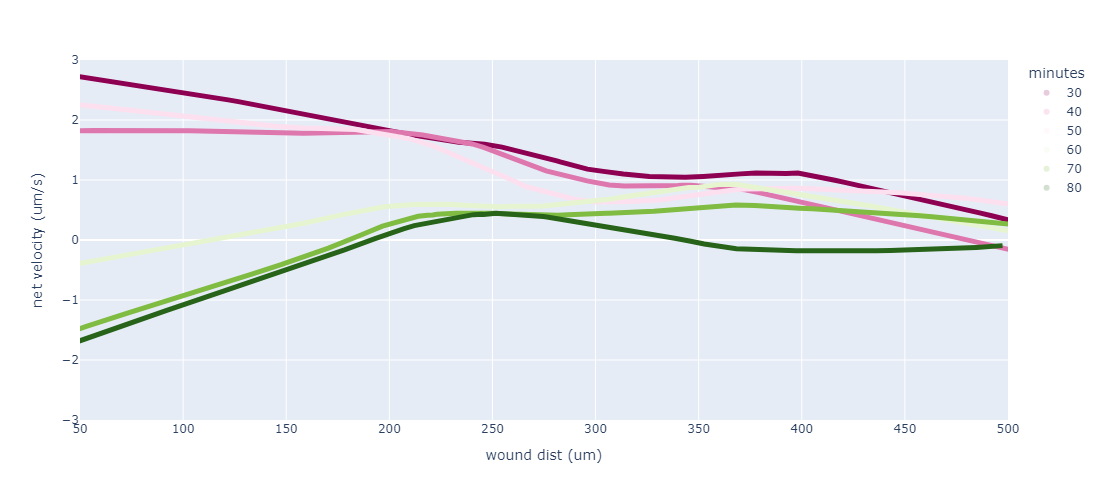

In [17]:
import matplotlib.cm as cm
from matplotlib.colors import Normalize

cmap = "PiYG"
frames=np.arange(30, 90, 10)

c_list = get_n_colors_from_colormap(cmap, len(frames))

ft = np.isin(vel_df["frame"],frames)

fig = px.scatter(vel_df.loc[ft], x="d0", y="net_vel", color="frame_cat",  trendline="lowess", opacity=0, color_discrete_sequence=c_list, 
                labels={"frame":"minutes", "frame_cat": "minutes", "net_vel": "net velocity (um/s)", "d0":"wound dist (um)"})
fig.update_yaxes(range=[-3, 3])  
fig.update_xaxes(range=[50, 500])  

iter = 0
for i in range(1,2*len(frames),2):
    fig.data[i].update(line_color=c_list[iter], line_width=5)
    iter+=1

fig.update_layout(
    autosize=False,
    width=500,
    height=500)

fig.write_image(figure_path + "net_vel_trends.png", scale=4)
fig.show()

In [ ]:
a = list(range(1,2*len(frames),2))
a

In [ ]:
vel_df["net_vel_total"] = np.sqrt(vel_df["dx"]**2+vel_df["dy"]**2+vel_df["dz"]**2)* 1.5 / time_window

frames=np.asarray([10, 20, 30,  40, 50, 60, 70])
ft = np.isin(vel_df["frame"],frames)

fig = px.scatter(vel_df.loc[ft], x="d0", y="net_vel_total", facet_col="frame",  trendline="lowess", opacity=0.1, 
                labels={"frame":"minutes", "net_vel_total": "net velocity (um/s)", "d0":"wound dist (um)"})
fig.update_yaxes(range=[0, 10])               
# fig.update_layout(xaxis_title="distance from wound (um)", yaxis_title="net velocity toward wound (um/minute)")
fig.show()

In [ ]:
fig = px.scatter_3d(tracks_df, x="x", y="y", z="z", color="track_id", opacity=0.1)
fig.add_trace(go.Scatter3d(x=wound_center_interp[:, 2], y=wound_center_interp[:, 1], z=wound_center_interp[:, 0], mode="markers"))
fig.show()

In [ ]:

vel_array = np.asarray(master_vel_vec)
plot_filter = (vel_array[:, 0] >= 10) & (vel_array[:, 0] <= 30)

plt.scatter(x=vel_array[plot_filter, 1], y=vel_array[plot_filter, 2])
plt.show()